In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sn

In [2]:
# Download de yfinance : AAPL
aapl = yf.download('AAPL')
# Log Prix
P_aapl = np.log(aapl['Adj Close'])
# Log Rendements
R_aapl = P_aapl.diff().dropna()
R_aapl.head()

[*********************100%***********************]  1 of 1 completed


Date
1980-12-15   -0.053581
1980-12-16   -0.076231
1980-12-17    0.024450
1980-12-18    0.028580
1980-12-19    0.059239
Name: Adj Close, dtype: float64

In [3]:
bmw = yf.download('BMW')
P_bmw = np.log(bmw['Adj Close'])
R_bmw = P_bmw.diff().dropna()

amzn = yf.download('AMZN')
P_amzn = np.log(amzn['Adj Close'])
R_amzn = P_amzn.diff().dropna()

carrefour = yf.download('CA.PA')
P_carrefour = np.log(carrefour['Adj Close'])
R_carrefour = P_carrefour.diff().dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
def moving_average_crossover(prices, A, B):
    # Calculer les moyennes mobiles pour les deux paramètres donnés
    ma1_values = prices.rolling(A).mean()
    ma2_values = prices.rolling(B).mean()

    # Initialiser un tableau de signaux avec zéros
    signals = np.zeros(len(prices))

    # Définir les signaux en fonction des croisements de moyennes mobiles
    for i in range(len(prices)):
        if ma1_values[i] > ma2_values[i] and ma1_values[i-1] <= ma2_values[i-1]:
            signals[i] = 1
        elif ma1_values[i] < ma2_values[i] and ma1_values[i-1] >= ma2_values[i-1]:
            signals[i] = -1

    return signals

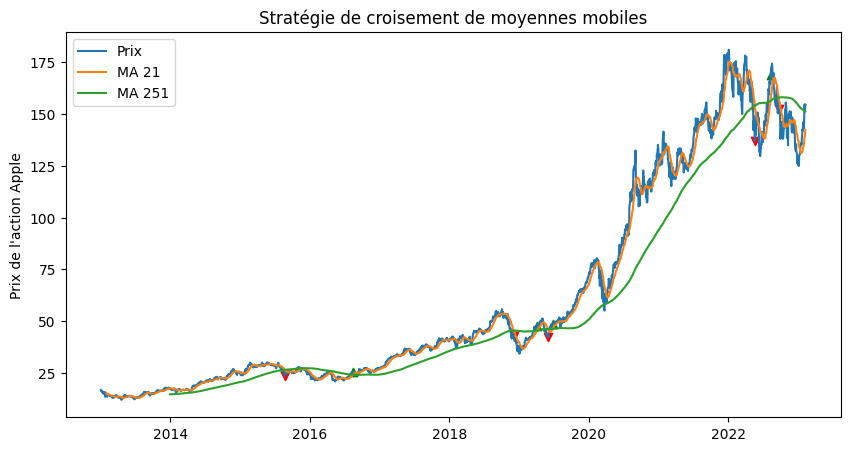

In [5]:
import matplotlib.pyplot as plt

prices = aapl['Adj Close']['2013':]
A = 21
B = 251

# Appliquer la stratégie de croisement de moyennes mobiles à des données de prix
signals = moving_average_crossover(prices, A, B)
ma1_values = prices.rolling(A).mean()
ma2_values = prices.rolling(B).mean()

# Tracer les prix et les moyennes mobiles sur un graphique
plt.figure(figsize=(10,5))
plt.title('Stratégie de croisement de moyennes mobiles')
plt.ylabel("Prix de l'action Apple")

plt.plot(prices, label='Prix')
plt.plot(ma1_values, label='MA {}'.format(A))
plt.plot(ma2_values, label='MA {}'.format(B))

# Tracer les signaux sur le graphique en utilisant des marqueurs de flèche
for i in range(len(signals)):
    if signals[i] == 1:
        plt.scatter(x=prices.index[i],y=prices.iloc[i], color='g', marker='^')
    elif signals[i] == -1:
        plt.scatter(x=prices.index[i], y=prices.iloc[i], color='r', marker='v')

plt.legend()
plt.show()

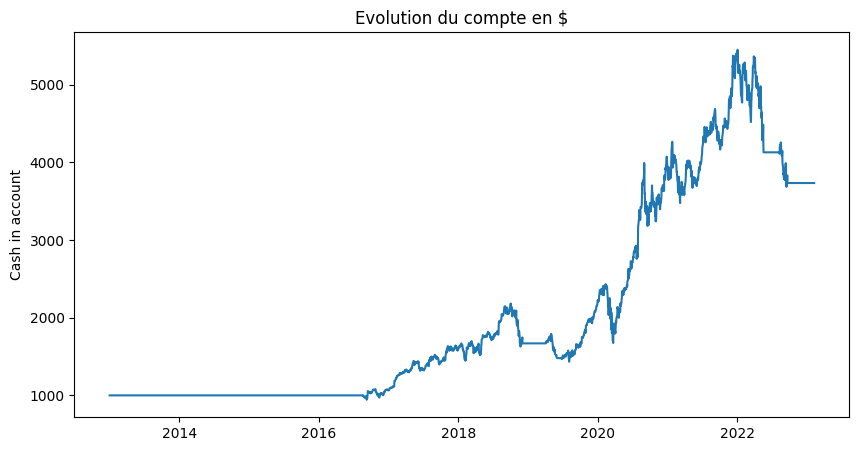

In [6]:
cash = [1000]
virtual_money = [1000]
portfolio = [0]

for i in range(1,len(prices)):
    if signals[i] == 1:
        share_to_buy = min(100,int(cash[-1]/prices[i]))
        if cash[-1] > share_to_buy*prices[i]:
            cash.append(cash[-1] - share_to_buy*prices[i])
            portfolio.append(portfolio[-1]+share_to_buy)
            virtual_money.append(cash[-1]+portfolio[-1]*prices[i])
        else:
            cash.append(cash[-1])
            virtual_money.append(cash[-1]+portfolio[-1]*prices[i])
    elif signals[i] == -1:
        cash.append(cash[-1] + portfolio[-1]*prices[i])
        portfolio.append(0)
        virtual_money.append(cash[-1]+portfolio[-1]*prices[i])
    else:
        cash.append(cash[-1])
        portfolio.append(portfolio[-1])
        virtual_money.append(cash[-1]+portfolio[-1]*prices[i])

cash = pd.DataFrame(data = cash, index = prices.index)
plt.figure(figsize=(10,5))
plt.title('Evolution du compte en $')
plt.ylabel('Cash in account')
plt.plot(cash.index, virtual_money)
plt.show()

In [10]:
virtual_money = pd.DataFrame(data = virtual_money, index = prices.index)

In [11]:
print(f"Argent gagné : {np.round(virtual_money.iloc[-1][0]-virtual_money.iloc[0][0])}$")
print(f"Profit généré sur 10 ans : {np.round(100*(virtual_money.iloc[-1][0]-virtual_money.iloc[0][0])/virtual_money[0],2)}%")

Argent gagné : 2735.0$
Profit généré sur 10 ans : Date
2013-01-02    273.50
2013-01-03    273.50
2013-01-04    273.50
2013-01-07    273.50
2013-01-08    273.50
               ...  
2023-02-02     73.23
2023-02-03     73.23
2023-02-06     73.23
2023-02-07     73.23
2023-02-08     73.23
Name: 0, Length: 2544, dtype: float64%


In [ ]:
def profit(strat, prices):
    
    signals = strat(prices)
    
    cash = [1000]
    virtual_money = [1000]
    portfolio = [0]

    for i in range(1,len(prices)):
        if signals[i] == 1:
            share_to_buy = min(100,int(cash[-1]/prices[i]))
            if cash[-1] > share_to_buy*prices[i]:
                cash.append(cash[-1] - share_to_buy*prices[i])
                portfolio.append(portfolio[-1]+share_to_buy)
                virtual_money.append(cash[-1]+portfolio[-1]*prices[i])
            else:
                cash.append(cash[-1])
                virtual_money.append(cash[-1]+portfolio[-1]*prices[i])
        elif signals[i] == -1:
            cash.append(cash[-1] + portfolio[-1]*prices[i])
            portfolio.append(0)
            virtual_money.append(cash[-1]+portfolio[-1]*prices[i])
        else:
            cash.append(cash[-1])
            portfolio.append(portfolio[-1])
            virtual_money.append(cash[-1]+portfolio[-1]*prices[i])

    cash = pd.DataFrame(data = cash, index = prices.index)
    
    return cash.iloc[-1][0]-cash.iloc[0][0]

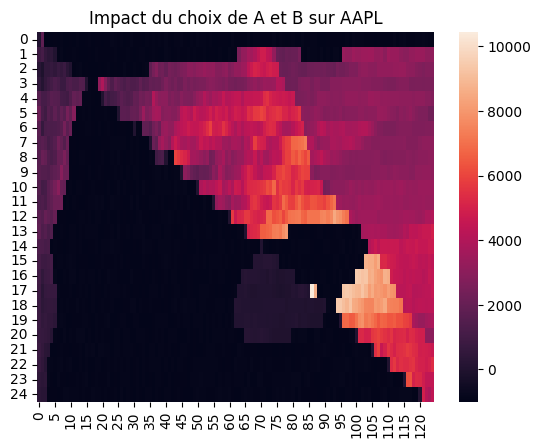

In [ ]:
A = np.arange(1, 251, 10)
B = np.arange(1, 251, 2)

grad_aapl = np.zeros((len(A),len(B)))

for i in range(len(A)):
    for j in range(len(B)):
        def mac(price): return moving_average_crossover(price, A[i], B[j])
        grad_aapl[i,j] = profit(mac,prices)

sn.heatmap(grad_aapl)
plt.title('Impact du choix de A et B sur AAPL')
plt.show()

In [ ]:
M = np.max(grad_aapl)
i, j = np.where(grad_aapl == M)
print(A[i], B[j])

[171] [173]


In [ ]:
def mac(price): return moving_average_crossover(price,181, 183)

total_profit = profit(mac,prices)
print(f"Argent gagné : {total_profit}$")

Argent gagné : -865.5351037979126$


De cette petite expérience, on dégage plusieurs conclusions :
1. Pas de pattern particulier
2. Stratégie optimale pour A = 151 et B = 1, donc comparer les résultats d'aujourd'hui à la moyenne sur 6 mois (environ)

## Stationnarité

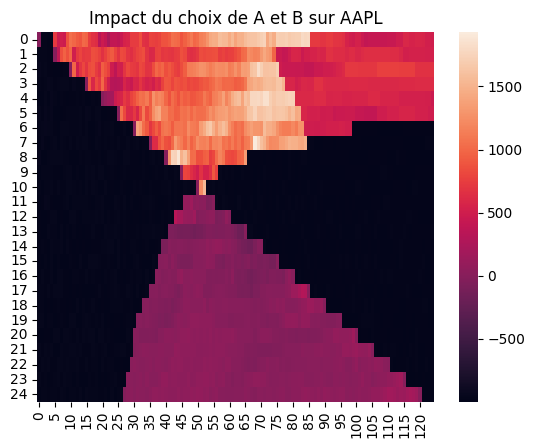

In [ ]:
grad_aapl1 = np.zeros((len(A),len(B)))
prices = aapl['Adj Close']['2013':'2018']

grad_aapl1 = np.zeros((len(A),len(B)))

for i in range(len(A)):
    for j in range(len(B)):
        def mac(price): return moving_average_crossover(price, A[i], B[j])
        grad_aapl1[i,j] = profit(mac,prices)

sn.heatmap(grad_aapl1)
plt.title('Impact du choix de A et B sur AAPL')
plt.show()

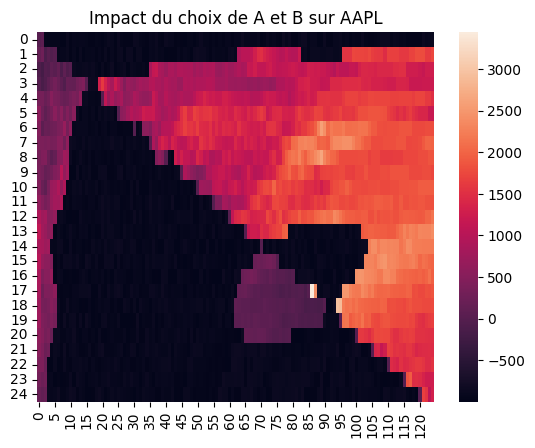

In [ ]:
grad_aapl2 = np.zeros((len(A),len(B)))
prices = aapl['Adj Close']['2018':]

for i in range(len(A)):
    for j in range(len(B)):
        def mac(price): return moving_average_crossover(price, A[i], B[j])
        grad_aapl2[i,j] = profit(mac,prices)

sn.heatmap(grad_aapl2)
plt.title('Impact du choix de A et B sur AAPL')
plt.show()

In [ ]:
print(f"Profit maximal sur la période 2013-2018 :{np.round(np.max(grad_aapl1),2)}")
print(f"Profit maximal sur la période 2018-2023 :{np.round(np.max(grad_aapl2),2)}")

Profit maximal sur la période 2013-2018 :1930.64
Profit maximal sur la période 2018-2023 :3444.6


## Retour à la moyenne

In [ ]:
def mean_reversion(prices, k, t):
    # Calculer la moyenne mobile et la volatilité
    avg_values = prices.rolling(t).mean()
    avg_vol = prices.rolling(t).std()

    # Initialiser un tableau de signaux avec zéros
    signals = np.zeros(len(prices))

    # Définir les signaux en fonction des croisements de moyennes mobiles
    for i in range(len(prices)):
        if prices[i] - avg_values[i] > k*avg_vol[i]:
            signals[i] = -1
        elif prices[i] - avg_values[i] < -k*avg_vol[i]:
            signals[i] = 1

    return signals

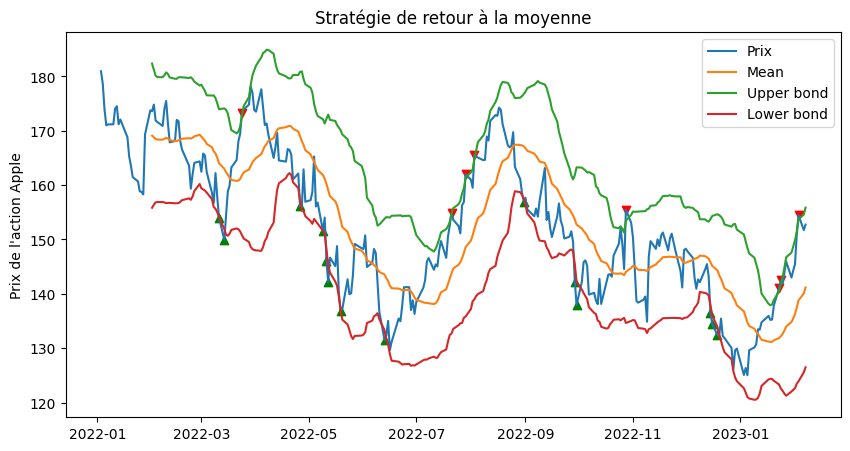

In [ ]:
import matplotlib.pyplot as plt

prices = aapl['Adj Close']['2022':]
k = 2
t = 21

# Appliquer la stratégie de croisement de moyennes mobiles à des données de prix
signals = mean_reversion(prices, k, t)
avg_values = prices.rolling(t).mean()
avg_vol = prices.rolling(t).std()

# Tracer les prix et les moyennes mobiles sur un graphique
plt.figure(figsize=(10,5))
plt.title('Stratégie de retour à la moyenne')
plt.ylabel("Prix de l'action Apple")

plt.plot(prices, label='Prix')
plt.plot(avg_values, label='Mean')
plt.plot(avg_values + k*avg_vol, label='Upper bond')
plt.plot(avg_values - k*avg_vol, label='Lower bond')

# Tracer les signaux sur le graphique en utilisant des marqueurs de flèche
for i in range(len(signals)):
    if signals[i] == 1:
        plt.scatter(x=prices.index[i],y=prices.iloc[i], color='g', marker='^')
    elif signals[i] == -1:
        plt.scatter(x=prices.index[i], y=prices.iloc[i], color='r', marker='v')

plt.legend()
plt.show()

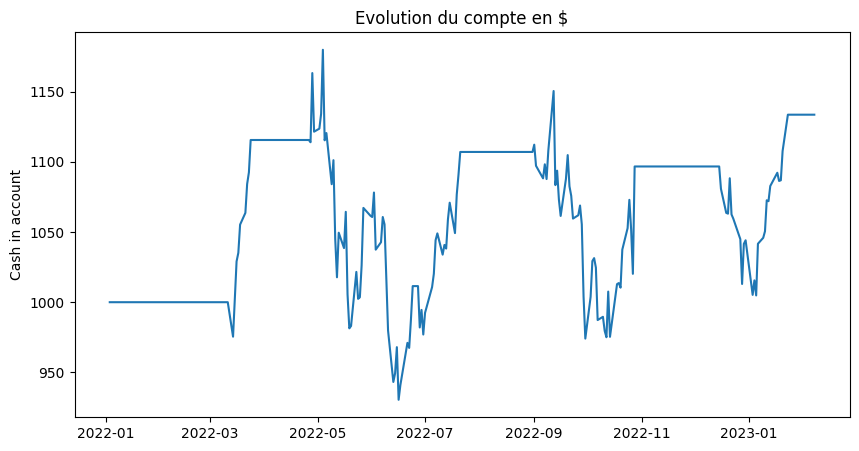

In [ ]:
cash = [1000]
virtual_money = [1000]
portfolio = [0]

for i in range(1,len(prices)):
    if signals[i] == 1:
        share_to_buy = min(100,int(cash[-1]/prices[i]))
        if cash[-1] > share_to_buy*prices[i]:
            cash.append(cash[-1] - share_to_buy*prices[i])
            portfolio.append(portfolio[-1]+share_to_buy)
            virtual_money.append(cash[-1]+portfolio[-1]*prices[i])
        else:
            cash.append(cash[-1])
            virtual_money.append(cash[-1]+portfolio[-1]*prices[i])
    elif signals[i] == -1:
        cash.append(cash[-1] + portfolio[-1]*prices[i])
        portfolio.append(0)
        virtual_money.append(cash[-1]+portfolio[-1]*prices[i])
    else:
        cash.append(cash[-1])
        portfolio.append(portfolio[-1])
        virtual_money.append(cash[-1]+portfolio[-1]*prices[i])

cash = pd.DataFrame(data = cash, index = prices.index)
plt.figure(figsize=(10,5))
plt.title('Evolution du compte en $')
plt.ylabel('Cash in account')
plt.plot(cash.index, virtual_money)
plt.show()

In [ ]:
print(f"Argent gagné : {np.round(cash.iloc[-1][0]-cash.iloc[0][0])}$")
print(f"Profit généré sur 10 ans : {np.round(100*(cash.iloc[-1][0]-cash.iloc[0][0])/cash.iloc[0][0],2)}%")

Argent gagné : 134.0$
Profit généré sur 10 ans : 13.35%


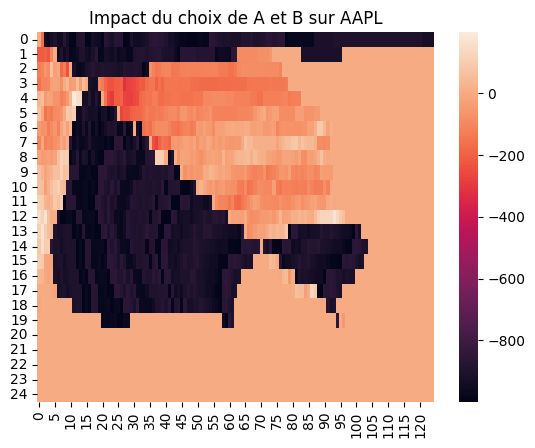

In [ ]:
k = np.arange(1, 201, 10)
t = np.arange(1, 201, 2)

grad_aapl = np.zeros((len(A),len(B)))

for i in range(len(A)):
    for j in range(len(B)):
        def mac(price): return moving_average_crossover(price, A[i], B[j])
        grad_aapl[i,j] = profit(mac,prices)

sn.heatmap(grad_aapl)
plt.title('Impact du choix de A et B sur AAPL')
plt.show()

## Stratégie personnelle

On a vu en cours qu'un marché calme est très dangereux. En effet, quand la volatilité est basse, la prédictabilité du marché augmente, ainsi, les agents ont plus tendance à sélectionner des stratégies similaires et donc a brisé l'équilibre du marché. La stratégie que je propose a donc pour but d'éviter ce genre de marché dangereux et tend à faire de petits gains sur des périodes de hautes volatilités. </br>
Formellement, on définit $\sigma_{t}(\alpha)$ la volatilité de la moyenne exponentielle de coefficient $\alpha$ jusqu'à $t$ et un seuil $\nu$. Puis, $\begin{equation}
  x_t =
    \begin{cases}
      1 & \text{si } |\sigma_t - \sigma_{t-1}| \leq \nu \\
      -1 & \text{si } \sigma_t - \sigma_{t-1} > \nu\\
      0 & \text{sinon}
    \end{cases}       
\end{equation}$

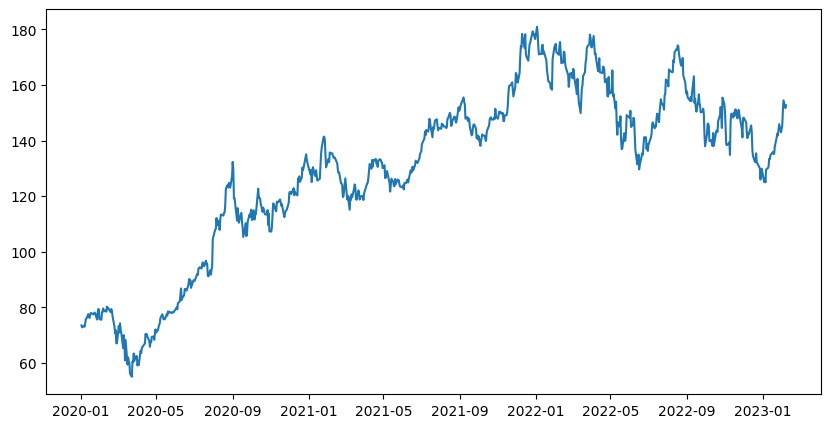

In [ ]:
plt.figure(figsize=(10,5))
prices = aapl['Adj Close']['2020':]
plt.plot(prices)
plt.show()

In [ ]:
def strategy_vol(prices, seuil, a):
    vol = prices.ewm(alpha=a).std()
    signals = np.zeros(len(prices))
    for i in range(1, len(prices)):
        if abs(vol[i-1]-vol[i-2]) <= seuil:
            signals[i] = -1
        elif vol[i-1] - vol[i-2] > seuil:
            signals[i] = 1
    return signals

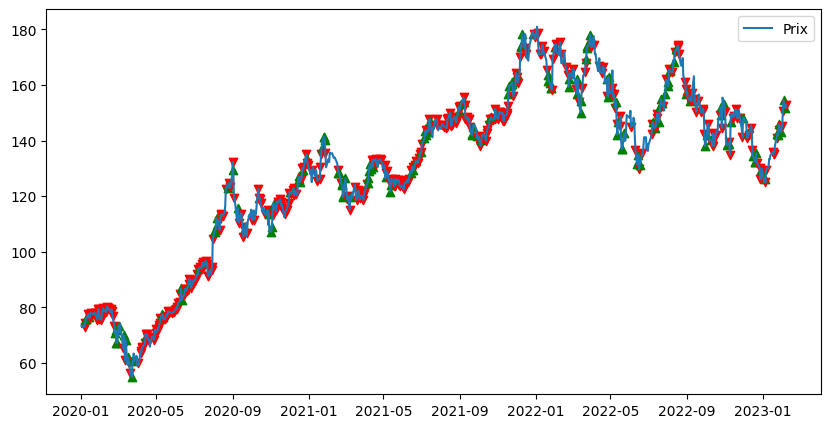

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(prices, label='Prix')
plt.legend()
signals = strategy_vol(prices, 0.2, 1/7)

# Tracer les signaux sur le graphique en utilisant des marqueurs de flèche
for i in range(len(signals)):
    if signals[i] == 1:
        plt.scatter(x=prices.index[i],y=prices.iloc[i], color='g', marker='^')
    elif signals[i] == -1:
        plt.scatter(x=prices.index[i], y=prices.iloc[i], color='r', marker='v')

plt.show()

In [ ]:
cash = [1000]
virtual_money = [1000]
portfolio = [0]

for i in range(1,len(prices)):
    if signals[i] == 1:
        share_to_buy = min(100,int(cash[-1]/prices[i]))
        if cash[-1] > share_to_buy*prices[i]:
            cash.append(cash[-1] - share_to_buy*prices[i])
            portfolio.append(portfolio[-1]+share_to_buy)
            virtual_money.append(cash[-1]+portfolio[-1]*prices[i])
        else:
            cash.append(cash[-1])
            virtual_money.append(cash[-1]+portfolio[-1]*prices[i])
    elif signals[i] == -1:
        cash.append(cash[-1] + portfolio[-1]*prices[i])
        portfolio.append(0)
        virtual_money.append(cash[-1]+portfolio[-1]*prices[i])
    else:
        cash.append(cash[-1])
        portfolio.append(portfolio[-1])
        virtual_money.append(cash[-1]+portfolio[-1]*prices[i])

cash = pd.DataFrame(data = cash, index = prices.index)

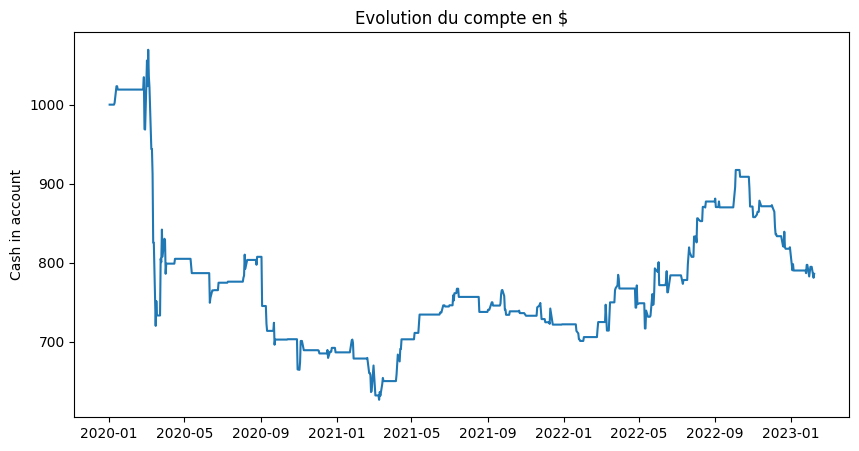

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Evolution du compte en $')
plt.ylabel('Cash in account')
#plt.plot(cash)
plt.plot(cash.index, virtual_money)
plt.show()

In [ ]:
print(f"Argent gagné : {np.round(virtual_money[-1]-virtual_money[0])}$")
print(f"Profit généré sur 1 ans : {np.round(100*(virtual_money[-1]-virtual_money[0])/virtual_money[0],2)}%")

Argent gagné : -214.0$
Profit généré sur 1 ans : -21.41%


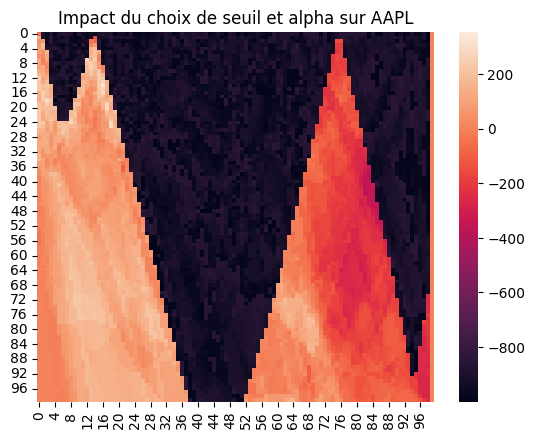

In [ ]:
seuil_range = np.linspace(0.01, 1, 100)
alpha_range = np.linspace(0.01, 1, 100)



grad_vol = np.zeros((len(seuil_range),len(alpha_range)))
prices = aapl['Adj Close']['2022':]

for i in range(len(seuil_range)):
    for j in range(len(alpha_range)):
        def strat(price): return strategy_vol(price, seuil_range[i], alpha_range[j])
        grad_vol[i,j] = profit(strat,prices)

sn.heatmap(grad_vol)
plt.title('Impact du choix de seuil et alpha sur AAPL')
plt.show()

In [ ]:
M = np.max(grad_vol)
i, j = np.where(grad_vol == M)
print(seuil_range[i], alpha_range[j])

[0.15] [0.17]


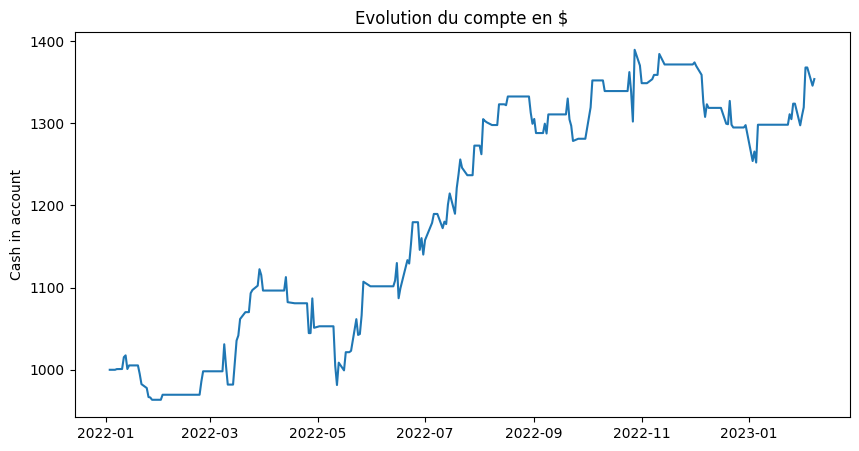

In [ ]:
signals = strategy_vol(prices, seuil_range[i], alpha_range[j])

cash = [1000]
virtual_money = [1000]
portfolio = [0]

for i in range(1,len(prices)):
    if signals[i] == 1:
        share_to_buy = min(100,int(cash[-1]/prices[i]))
        if cash[-1] > share_to_buy*prices[i]:
            cash.append(cash[-1] - share_to_buy*prices[i])
            portfolio.append(portfolio[-1]+share_to_buy)
            virtual_money.append(cash[-1]+portfolio[-1]*prices[i])
        else:
            cash.append(cash[-1])
            virtual_money.append(cash[-1]+portfolio[-1]*prices[i])
    elif signals[i] == -1:
        cash.append(cash[-1] + portfolio[-1]*prices[i])
        portfolio.append(0)
        virtual_money.append(cash[-1]+portfolio[-1]*prices[i])
    else:
        cash.append(cash[-1])
        portfolio.append(portfolio[-1])
        virtual_money.append(cash[-1]+portfolio[-1]*prices[i])

cash = pd.DataFrame(data = cash, index = prices.index)
plt.figure(figsize=(10,5))
plt.title('Evolution du compte en $')
plt.ylabel('Cash in account')
plt.plot(cash.index, virtual_money)
plt.show()

In [ ]:
print(f"Argent gagné : {np.round(cash.iloc[-1][0]-cash.iloc[0][0])}$")
print(f"Profit généré sur 1 ans : {np.round(100*(cash.iloc[-1][0]-cash.iloc[0][0])/cash.iloc[0][0],2)}%")

Argent gagné : 354.0$
Profit généré sur 1 ans : 35.38%


[*********************100%***********************]  1 of 1 completed


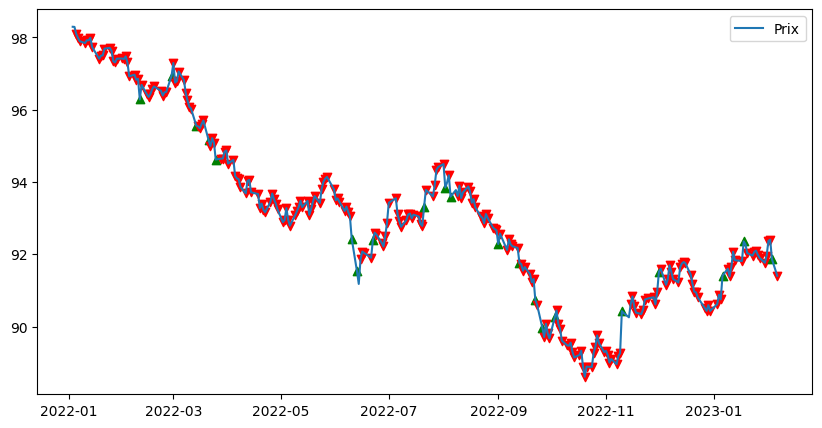

In [ ]:
def strategy_vol(prices, seuil,a):
    vol = prices.ewm(alpha=a).std()
    signals = np.zeros(len(prices))
    for i in range(1, len(prices)):
        if abs(vol[i]-vol[i-1])<= seuil:
            signals[i] = -1
        elif vol[i] - vol[i-1] > seuil:
            signals[i] = 1
    return signals

stock = yf.download('BTC')
prices = stock['Adj Close']['2022':]
plt.figure(figsize=(10,5))
plt.plot(prices, label='Prix')
plt.legend()
signals = strategy_vol(prices, 0.2, 0.8)

# Tracer les signaux sur le graphique en utilisant des marqueurs de flèche
for i in range(len(signals)):
    if signals[i] == 1:
        plt.scatter(x=prices.index[i],y=prices.iloc[i], color='g', marker='^')
    elif signals[i] == -1:
        plt.scatter(x=prices.index[i], y=prices.iloc[i], color='r', marker='v')

plt.show()

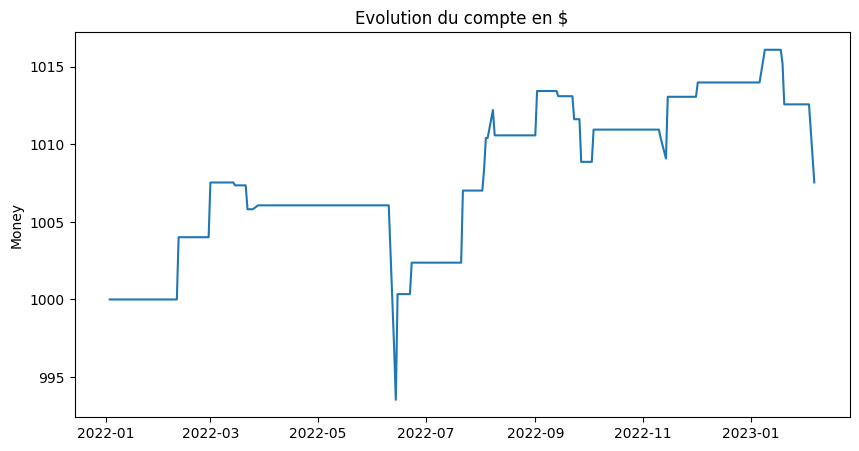

In [ ]:
cash = [1000]
virtual_money = [1000]
portfolio = [0]

for i in range(1,len(prices)):
    if signals[i] == 1:
        share_to_buy = min(100,int(cash[-1]/prices[i]))
        if cash[-1] > share_to_buy*prices[i]:
            cash.append(cash[-1] - share_to_buy*prices[i])
            portfolio.append(portfolio[-1]+share_to_buy)
            virtual_money.append(cash[-1]+portfolio[-1]*prices[i])
        else:
            cash.append(cash[-1])
            virtual_money.append(cash[-1]+portfolio[-1]*prices[i])
    elif signals[i] == -1:
        cash.append(cash[-1] + portfolio[-1]*prices[i])
        portfolio.append(0)
        virtual_money.append(cash[-1]+portfolio[-1]*prices[i])
    else:
        cash.append(cash[-1])
        portfolio.append(portfolio[-1])
        virtual_money.append(cash[-1]+portfolio[-1]*prices[i])

cash = pd.DataFrame(data = cash, index = prices.index)
plt.figure(figsize=(10,5))
plt.title('Evolution du compte en $')
plt.ylabel('Money')
plt.plot(cash.index, virtual_money)
plt.show()

In [ ]:
print(f"Argent gagné : {np.round(cash.iloc[-1][0]-cash.iloc[0][0])}$")
print(f"Profit généré sur 1 ans : {np.round(100*(cash.iloc[-1][0]-cash.iloc[0][0])/cash.iloc[0][0],2)}%")

Argent gagné : 8.0$
Profit généré sur 1 ans : 0.76%
